In [ ]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu116


In [ ]:
!pip install albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement 0.5.2 (from versions: none)
ERROR: No matching distribution found for 0.5.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import copy
from collections import defaultdict
import shutil
import pandas as pd
from skimage import io, transform
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision
from PIL import Image
from torch.autograd import Variable
import torch.nn as nn
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.pytorch.transforms import ToTensorV2
import torch.nn.functional as F
from torch import Tensor
from torchvision import transforms, utils
from torchvision.datasets import ImageFolder
# from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader, random_split
from torch import optim
from tqdm import tqdm
from torch import flatten
import zipfile,os
import time

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
TRAIN_PATH = '/content/Datasets/train/'
TEST_PATH = '/content/Datasets/test/'
CHECKPOINT_PATH = '/content/drive/MyDrive/Dataset_ML/Nuclei_Datasets/checkpoint'
BEST_MODEL_PATH = '/content/drive/MyDrive/Dataset_ML/Nuclei_Datasets/bestmodel.pt'
EPOCHS = 11
LR = 1e-3
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Load Dataset

In [ ]:
# Create new path
os.mkdir('Datasets')

In [ ]:
# zip extraction
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Dataset_ML/Nuclei_Datasets/stage1_train.zip', 'r')
zip_ref.extractall('Datasets/train')
zip_ref.close()

In [ ]:
# zip extraction
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Dataset_ML/Nuclei_Datasets/stage1_test.zip', 'r')
zip_ref.extractall('Datasets/test')
zip_ref.close()

### Data Exploration

In [ ]:
def get_transforms(mean, std):
    list_transforms = []
    list_transforms.extend([HorizontalFlip(p=0.5)])
    list_transforms.extend([Normalize(mean=mean, std=std, p=1),ToTensorV2()])
    list_trfms = Compose(list_transforms)
    return list_trfms

class Nuclie_data(Dataset):
        def __init__(self,path):
            self.path = path
            self.folders = os.listdir(path)
            self.transforms = get_transforms(0.5, 0.5)
        
        def __len__(self):
            return len(self.folders)
              
        
        def __getitem__(self,idx):
            image_folder = os.path.join(self.path,self.folders[idx],'images/')
            mask_folder = os.path.join(self.path,self.folders[idx],'masks/')
            image_path = os.path.join(image_folder,os.listdir(image_folder)[0])
            
            img = io.imread(image_path)[:,:,:3].astype('float32')
            img = transform.resize(img,(128,128))
            
            mask = self.get_mask(mask_folder, 128, 128 ).astype('float32')

            augmented = self.transforms(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
            mask = mask.permute(2, 0, 1)
            return (img,mask) 


        def get_mask(self,mask_folder,IMG_HEIGHT, IMG_WIDTH):
            mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
            for mask_ in os.listdir(mask_folder):
                    mask_ = io.imread(os.path.join(mask_folder,mask_))
                    mask_ = transform.resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
                    mask_ = np.expand_dims(mask_,axis=-1)
                    mask = np.maximum(mask, mask_)
              
            return mask

In [ ]:
#loading the data
train_ds = Nuclie_data('/content/Datasets/train')

In [ ]:
print(train_ds.__len__())
train_ds.__getitem__(0)

670


(tensor([[[-0.8996, -0.8963, -0.8981,  ..., -0.8912, -0.8941, -0.8924],
          [-0.8943, -0.8963, -0.8979,  ..., -0.8959, -0.8963, -0.8977],
          [-0.8941, -0.8988, -0.8966,  ..., -0.8994, -0.8996, -0.9027],
          ...,
          [-0.8996, -0.8920, -0.8990,  ..., -0.9047, -0.9073, -0.9073],
          [-0.8982, -0.8971, -0.8958,  ..., -0.9039, -0.9024, -0.9028],
          [-0.8967, -0.8963, -0.8972,  ..., -0.9089, -0.9065, -0.9129]],
 
         [[-0.8996, -0.8963, -0.8981,  ..., -0.8912, -0.8941, -0.8924],
          [-0.8943, -0.8963, -0.8979,  ..., -0.8959, -0.8963, -0.8977],
          [-0.8941, -0.8988, -0.8966,  ..., -0.8994, -0.8996, -0.9027],
          ...,
          [-0.8996, -0.8920, -0.8990,  ..., -0.9047, -0.9073, -0.9073],
          [-0.8982, -0.8971, -0.8958,  ..., -0.9039, -0.9024, -0.9028],
          [-0.8967, -0.8963, -0.8972,  ..., -0.9089, -0.9065, -0.9129]],
 
         [[-0.8996, -0.8963, -0.8981,  ..., -0.8912, -0.8941, -0.8924],
          [-0.8943, -0.8963,

In [ ]:
# Check image and mask size
for img,msk in train_ds:
  print(img.shape)
  print(msk.shape)
  break

torch.Size([3, 128, 128])
torch.Size([1, 128, 128])


### Convert Tensor to Image

In [ ]:
def mask_convert(mask):
    mask = mask.clone().cpu().detach().numpy()
    mask = mask.transpose((1,2,0))
    std = np.array((0.5))
    mean = np.array((0.5))
    mask  = std * mask + mean
    mask = mask.clip(0,1)
    mask = np.squeeze(mask)
    return mask

def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    std = np.array((0.5,0.5,0.5))
    mean = np.array((0.5,0.5,0.5))
    image  = std * image + mean
    image = image.clip(0,1)
    image = (image * 255).astype(np.uint8)
    return image

### Splitting Data

In [ ]:
n_val = int(len(train_ds) * 0.15)
n_train = len(train_ds) - n_val
train_set, val_set = random_split(train_ds, [n_train, n_val])
                                  
train_loader = DataLoader(dataset=train_set, batch_size=10, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=10)

In [ ]:
len(train_set)

570

In [ ]:
len(val_set)

100

### Show image

In [ ]:
def plot_img(num):
    loop = iter(train_loader)
    images,masks = next(loop)
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)
    plt.figure(figsize=(10,6))
    for idx in range(0,num):
         image = image_convert(images[idx])
         plt.subplot(2,num,idx+1)
         plt.title('image')
         plt.imshow(image)
    for idx in range(0,num):
         mask = mask_convert(masks[idx])
         plt.subplot(2,num,idx+num+1)
         plt.title('mask')
         plt.imshow(mask,cmap='gray')
    plt.show()

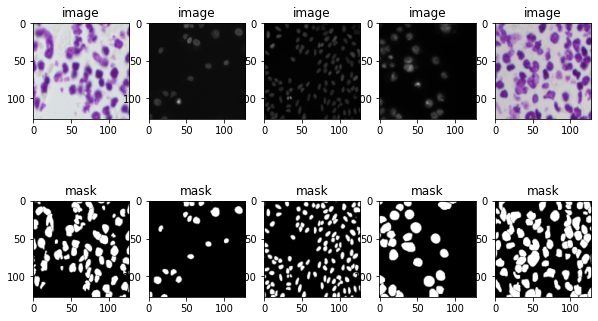

In [ ]:
plot_img(5)

### Building Model

In [ ]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

class UnetMod(nn.Module):
    def __init__(self):
        super().__init__()
        self.dblock1 = double_conv(3, 64)
        self.dblock2 = double_conv(64, 128)
        self.dblock3 = double_conv(128,256)
        self.dblock4 = double_conv(256,512)

        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) 

        self.dblock5 = double_conv(256 + 512, 256)
        self.dblock6 = double_conv(128 + 256, 128)
        self.dblock7 = double_conv(128 + 64, 64)

        self.last_layer = nn.Conv2d(64,1,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        conv1 = self.dblock1(x)
        x = self.pool(conv1)

        conv2 = self.dblock2(x)
        x = self.pool(conv2)

        conv3 = self.dblock3(x)
        x = self.pool(conv3)

        conv4 = self.dblock4(x)
        
        x = self.upsample(conv4)

        x = torch.cat([x, conv3], dim=1)

        x = self.dblock5(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        
        x = self.dblock6(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        
        x = self.dblock7(x)

        out = self.last_layer(x)
        # out = self.sigmoid(x)
        return out

In [ ]:
model = UnetMod().to(DEVICE)
model

UnetMod(
  (dblock1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dblock2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dblock3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dblock4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride

### Dice Loss

In [ ]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        bce_weight = 0.5
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        loss_final = BCE * bce_weight + dice_loss * (1 - bce_weight)
        return loss_final

### Save Checkpoint

In [ ]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    # save checkpoint data
    torch.save(state, checkpoint_path)
    if is_best:
        shutil.copyfile(checkpoint_path, best_model_path)
        
def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    valid_loss_min = checkpoint['valid_loss_min']

    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

### Training

In [ ]:
criterion = DiceBCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# optimizer = optim.RMSprop(model.parameters(), lr=LR, weight_decay=1e-8, momentum=0.999, foreach=True)
valid_loss_min = 3.95275

In [ ]:
startTime = time.time()

In [ ]:
def iou_(y_pred,y):
    inputs = y_pred.reshape(-1)
    targets = y.reshape(-1)
    intersection = (inputs * targets).sum()
    total = (inputs + targets).sum()
    union = total - intersection 
    smooth = 1    
    iou = (intersection + smooth)/(union + smooth)
    return iou

def iou_batch(y_pred,y):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    y_pred = torch.sigmoid(y_pred)
    y_pred = y_pred.clone().cpu().detach().numpy()
    y = y.clone().cpu().detach().numpy() 
    
    for pred, label in zip(y_pred, y):
        ious.append(iou_(pred, label))
    iou = np.nanmean(ious)
    return iou

In [ ]:
train_loss,val_loss = [],[]
train_iou,val_iou = [],[]

for epoch in range(EPOCHS):
    print('Epoch {}/{}'.format(epoch + 1, EPOCHS))
    start_time = time.time()

    running_train_loss = []
    running_train_score = []
    for image,mask in train_loader: 
            image = image.to(DEVICE,dtype=torch.float)
            mask = mask.to(DEVICE,dtype=torch.float)
            
            pred_mask = model.forward(image) # forward propogation
            loss = criterion(pred_mask,mask)
            score = iou_batch(pred_mask,mask)
            optimizer.zero_grad() # setting gradient to zero
            loss.backward()
            optimizer.step()
            running_train_loss.append(loss.item())
            running_train_score.append(score)
                              

    else:           
        running_val_loss = []
        running_val_score = []
        with torch.no_grad():
            for image,mask in val_loader:
                    image = image.to(DEVICE,dtype=torch.float)
                    mask = mask.to(DEVICE,dtype=torch.float)                            
                    pred_mask = model.forward(image)
                    loss = criterion(pred_mask,mask)
                    score = iou_batch(pred_mask,mask)
                    running_val_loss.append(loss.item())
                    running_val_score.append(score)

    epoch_train_loss,epoch_train_score = np.mean(running_train_loss) ,np.mean(running_train_score)
    print('Train loss: {:.6f}, IOU Score: {:.4f}'.format(epoch_train_loss,epoch_train_score))                       
    train_loss.append(epoch_train_loss)
    train_iou.append(epoch_train_score)
    
    epoch_val_loss,epoch_val_score = np.mean(running_val_loss),np.mean(running_val_score)
    print('Validation loss: {:.6f}, IOU Score: {:.4f}'.format(epoch_val_loss,epoch_val_score))                                
    val_loss.append(epoch_val_loss)
    val_iou.append(epoch_val_score)
    
    # create checkpoint variable and add important data
    checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': epoch_val_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
    
    # save checkpoint
    save_ckp(checkpoint, False, CHECKPOINT_PATH, BEST_MODEL_PATH)
    if epoch_val_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  \nSaving model ...\n'.format(valid_loss_min,epoch_val_loss))
            # save checkpoint as best model
            save_ckp(checkpoint, True, CHECKPOINT_PATH, BEST_MODEL_PATH)
            valid_loss_min = epoch_val_loss
    
    time_elapsed = time.time() - start_time
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Epoch 1/11
Train loss: 0.612741, IOU Score: 0.1522
Validation loss: 0.485715, IOU Score: 0.3006
Validation loss decreased (3.952750 --> 0.485715).  
Saving model ...

20m 55s
Epoch 2/11
Train loss: 0.375715, IOU Score: 0.3504
Validation loss: 0.413577, IOU Score: 0.4213
Validation loss decreased (0.485715 --> 0.413577).  
Saving model ...

20m 26s
Epoch 3/11
Train loss: 0.379612, IOU Score: 0.4063
Validation loss: 0.284824, IOU Score: 0.5175
Validation loss decreased (0.413577 --> 0.284824).  
Saving model ...

20m 27s
Epoch 4/11
Train loss: 0.288038, IOU Score: 0.4905
Validation loss: 0.232849, IOU Score: 0.5373
Validation loss decreased (0.284824 --> 0.232849).  
Saving model ...

20m 28s
Epoch 5/11
Train loss: 0.239597, IOU Score: 0.5443
Validation loss: 0.233646, IOU Score: 0.5909
20m 31s
Epoch 6/11
Train loss: 0.190128, IOU Score: 0.6180
Validation loss: 0.168549, IOU Score: 0.6565
Validation loss decreased (0.232849 --> 0.168549).  
Saving model ...

20m 26s
Epoch 7/11
Train loss

In [ ]:
endTime = time.time()
print("Total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

Total time taken to train the model: 14937.85s


### Loss and IOU Score Visualization

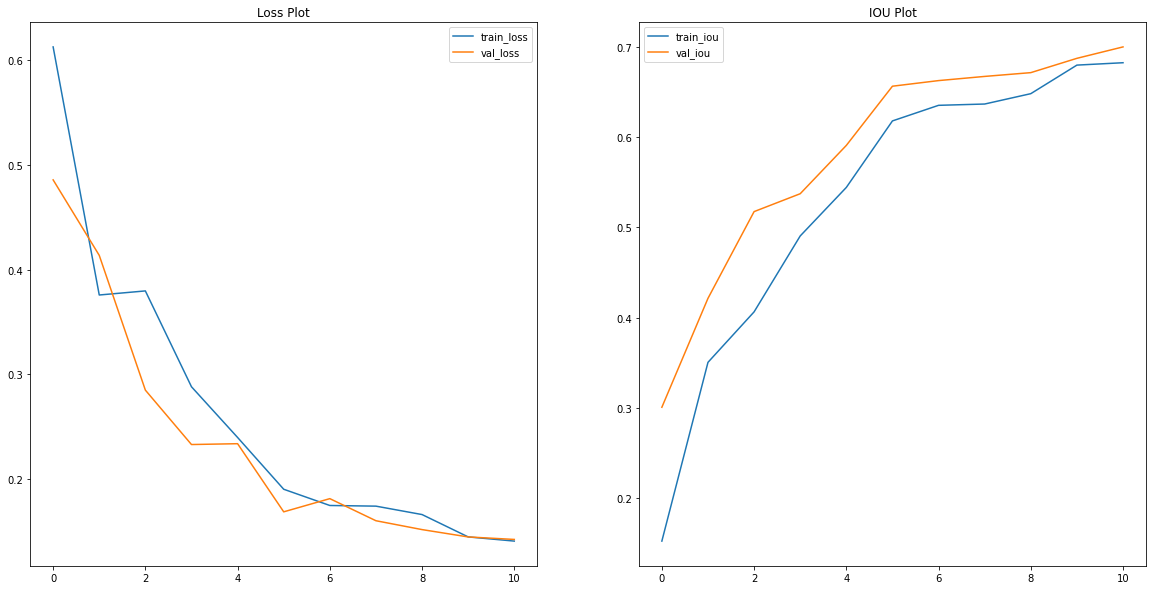

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(train_loss,label='train_loss')
plt.plot(val_loss,label='val_loss')
plt.legend()
plt.title('Loss Plot')
plt.subplot(1,2,2)
plt.plot(train_iou,label='train_iou')
plt.plot(val_iou,label='val_iou')
plt.legend()
plt.title('IOU Plot')
plt.show()

### Testing

In [ ]:
model = torch.load(open('bestmodel.pt', 'rb'))

In [ ]:
#loading the saved model
model, optimizer, start_epoch, valid_loss_min = load_ckp(CHECKPOINT_PATH, model, optimizer)

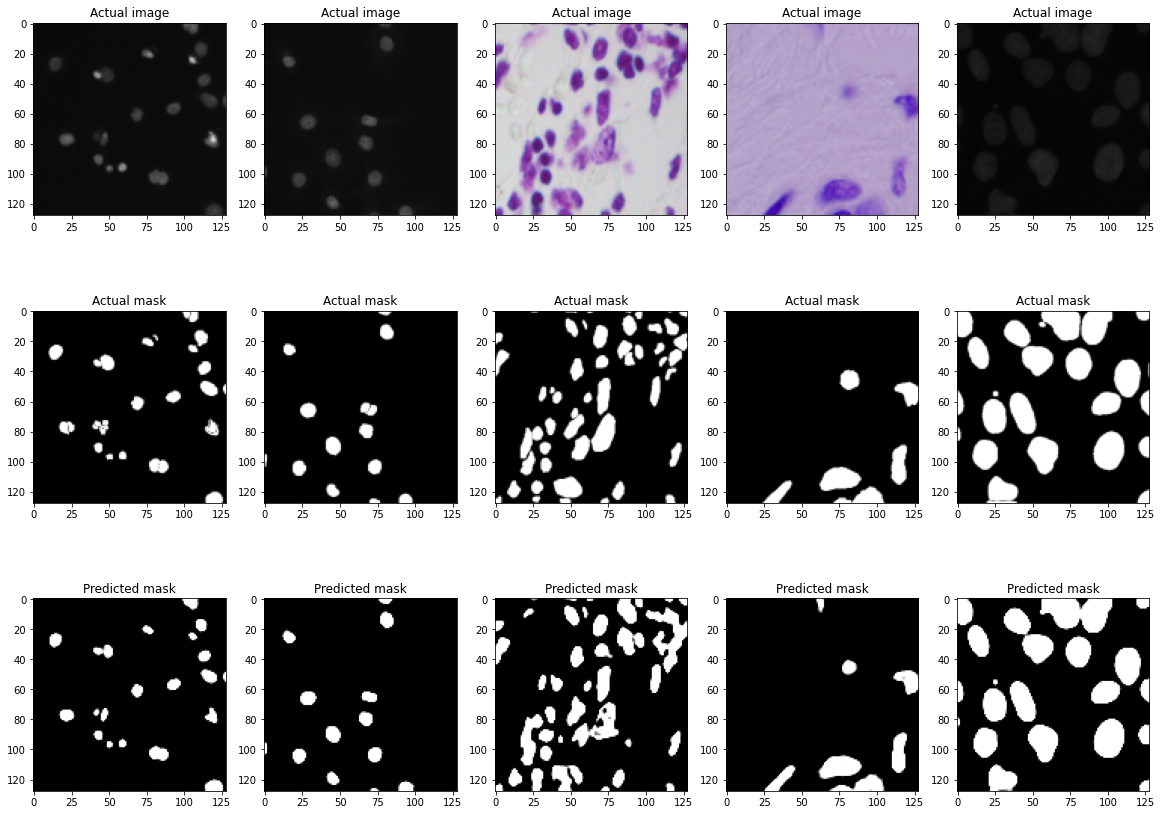

In [ ]:
loop1 = iter(val_loader)
image,mask = next(loop1)
image = image.to(DEVICE,dtype=torch.float)
mask = mask.to(DEVICE,dtype=torch.float)
y_pred = model.forward(image)

plt.figure(figsize=(20,15))
for i in range(0,5):
    plt.subplot(3,5,i+1)
    plt.title('Actual image')
    plt.imshow(image_convert(image[i]))
for i in range(0,5):
    plt.subplot(3,5,i+5+1)
    plt.title('Actual mask')
    plt.imshow(mask_convert(mask[i]),cmap='gray')
for i in range(0,5):
    plt.subplot(3,5,i+10+1)
    plt.title('Predicted mask')
    plt.imshow(mask_convert(y_pred[i]),cmap='gray')
plt.show()